In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
data = pd.read_csv('mnist_dataset.csv')
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
image = data.iloc[3] #select image at index 3
impage = np.array(image).astype('float32')

#784 = 28*28
image = np.reshape(image, (28,28)) #reshape
image = image/255 #(normalize 0,1)


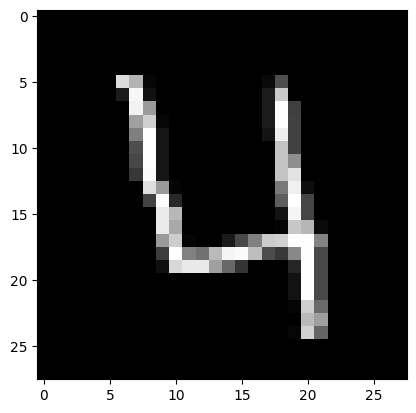

In [4]:
plt.imshow(image,cmap = 'gray')

In [6]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0,1)

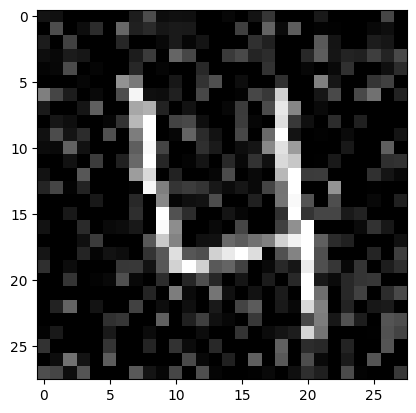

In [7]:
plt.imshow(noisy_image, cmap='gray')


# Data Preperation

In [21]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

In [27]:
class MNIST_AE_Dataset(Dataset):
    def __init__(self, csv_file, noise_factor = 0.2, transform = None):

        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img, (28,28,1))/255
        noisy_image = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_image = np.clip(noisy_image, 0, 1)

        sample = (noisy_image, img)

        if self.transform:
            sample = self.transform(sample)

        return sample
    

    


### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

# For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
# and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [28]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv', transform = ToTensorForAE())
print("size of trainset : {}". format(len(trainset)))

size of trainset : 42000


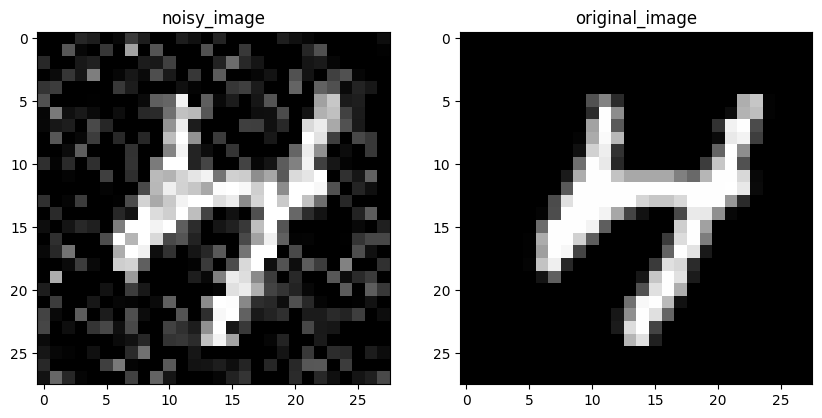

In [30]:
noisy_img, org_img = trainset[32]
show_image(noisy_img, org_img)

# Load dataset into batches

In [31]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size = 16, shuffle =True)


In [33]:
dataiter = iter(trainloader)
noisy_img, org_img = next(dataiter)

print("Shape of loading one batch : {}".format(noisy_img.shape))

print("Total no batches: {}".format(len(trainloader)))
print("Total no examples: {}".format(len(trainloader.dataset)))


Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total no batches: 2625
Total no examples: 42000


# Create AutoEncoder Model

In [43]:
from torch import nn
from torchsummary import summary

In [49]:
def Encoder():
    enc = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels= 16, kernel_size=(3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels = 16, out_channels=32, kernel_size=(3,3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    return enc

In [50]:
def Decoder():
    dec = nn.Sequential(
        nn.ConvTranspose2d(in_channels = 32, out_channels= 16, kernel_size=(2,2),stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16, out_channels= 1, kernel_size=(2,2),stride = 2),
        nn.Sigmoid()
    )
    return dec

In [51]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self,inp_imgs):

        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)

        return decoder_out
    
model = AutoEncoder()
model 

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

# Train AutoEncoder Model 

In [58]:
from tqdm import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 10

In [62]:
for i in range(epochs):
    train_loss = 0.0

    model.train()

    for batch in tqdm(trainloader):
        noisy_img, org_img = batch
        denoised_img = model(noisy_img)
        loss = criterion(denoised_img, org_img)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(trainloader)

    print("Epoch : {} Train Loss : {}".format(i+1, avg_train_loss))

100%|██████████| 2625/2625 [00:20<00:00, 126.00it/s]


Epoch : 1 Train Loss : 0.012611576030208242


100%|██████████| 2625/2625 [00:20<00:00, 129.38it/s]


Epoch : 2 Train Loss : 0.0055518762887943355


100%|██████████| 2625/2625 [00:19<00:00, 131.70it/s]


Epoch : 3 Train Loss : 0.005183459225155058


100%|██████████| 2625/2625 [00:20<00:00, 127.95it/s]


Epoch : 4 Train Loss : 0.004960199037744176


100%|██████████| 2625/2625 [00:18<00:00, 138.19it/s]


Epoch : 5 Train Loss : 0.004825240049067707


100%|██████████| 2625/2625 [00:18<00:00, 140.61it/s]


Epoch : 6 Train Loss : 0.004734216496969263


100%|██████████| 2625/2625 [00:19<00:00, 137.93it/s]


Epoch : 7 Train Loss : 0.004658459385945684


100%|██████████| 2625/2625 [00:18<00:00, 141.50it/s]


Epoch : 8 Train Loss : 0.00460009937964025


100%|██████████| 2625/2625 [00:18<00:00, 141.46it/s]


Epoch : 9 Train Loss : 0.004544560229050971


100%|██████████| 2625/2625 [00:18<00:00, 138.57it/s]

Epoch : 10 Train Loss : 0.004496413405541153


# Plot Results

torch.Size([1, 28, 28])


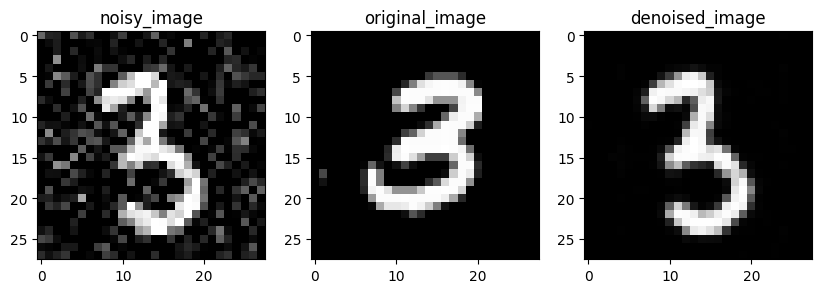

In [69]:
model.eval()
with torch.no_grad():

    dataiter = iter(trainloader)
    sample = next(dataiter)

    noisy_image, org_img = sample

    index = 4

    denoised_img = model(noisy_img[index].unsqueeze(0))
    print(denoised_img.squeeze(0).shape)

    show_image(noisy_img[index], org_img[index], denoised_img.squeeze(0))